In [1]:
import pandas as pd
import numpy as np
import collections
import re
import operator #
import matplotlib.pyplot as plt
from itertools import islice
from dateutil.parser import parse
import datetime
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
def URLcleaner(a):
    if 'http://' in a:
        a = a.replace('http://', '')
    if len(a.split('.'))>2:
        return a.split('.')[1].split('.')[0]
    else:
        return a.split('.')[0]

In [3]:
def timeOfDay(date):
    #dt = parse(date)
    if date.hour < 12:
        return "1Morning"
    if date.hour>= 12 and date.hour <= 15:
        return "2Afternoon"
    if date.hour> 15 and date.hour < 21:
        return "3Evening"
    else:
        return "4Night"

In [4]:
from datetime import datetime, date
def time2date(x):
    return datetime.combine(date.today(), x) 

In [5]:
#Load the dataset
data = pd.read_csv("/Users/Rohit/Desktop/Data/test.txt", sep="\t")
data.shape

(3614506, 5)

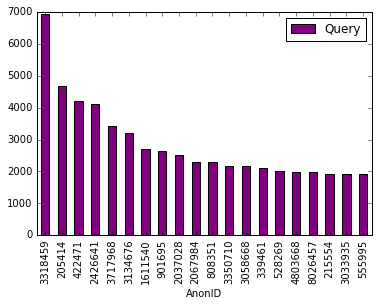

In [6]:
commonusers = data.groupby(['AnonID'])['Query'].count().to_frame()
commonusers= commonusers.sort_values(by='Query', ascending=False)
commonusers.head(20).plot(kind='bar', color='purple')

In [7]:
from difflib import SequenceMatcher

def similar(a, b):
    return round(SequenceMatcher(None, a, b).ratio(),2)

In [8]:
import enchant
d = enchant.Dict("en_US")

def spellchk(i):
    wsum = 0 
    for word in i.split():
        if d.check(word):
            wsum = wsum +1
    if wsum == len(i.split()):
        return True
    else:
        return False

In [9]:
#data['QuerySpellCheck'] = data.Query.apply(lambda x: spellchk(x))

In [10]:
data[data.AnonID==479].head()

,AnonID,Query,QueryTime,ItemRank,ClickURL
0,479,family guy,2006-03-01 16:01:20,NaN,NaN
1,479,also sprach zarathustra,2006-03-02 14:48:55,NaN,NaN
2,479,family guy movie references,2006-03-03 22:37:46,1.0,http://www.familyguyfiles.com
3,479,top grossing movies of all time,2006-03-03 22:42:42,1.0,http://movieweb.com
4,479,top grossing movies of all time,2006-03-03 22:42:42,2.0,http://www.imdb.com


In [11]:
userlist = data.AnonID.unique()
len(userlist) #No of unique users

66000

In [12]:
querylist = data.Query.unique()
len(querylist)

# fig.savefig('asdf.png')

1244496

In [13]:
queries = data.Query
faq = pd.DataFrame({'Query': queries.value_counts().index, 'Count':queries.value_counts()})
faq.index = range(faq.shape[0])
faq.head()

,Count,Query
0,98554,-
1,32396,google
2,13344,yahoo
3,12949,ebay
4,8733,yahoo.com


In [14]:
toomany = data[data.ItemRank >5.0]
initial = data[data.ItemRank<=5.0]

oftenAsked = set(initial.Query) & set(toomany.Query)
stillTrying= toomany.loc[toomany['Query'].isin(oftenAsked)]

In [15]:
st = stillTrying.groupby(['Query'])['ItemRank'].max()
mostAttempts = st.to_frame()
mostAttempts['Queries'] = list(mostAttempts.index)

In [16]:
mostAttempts = mostAttempts.reset_index(drop=True)
mostAttempts.head()

,ItemRank,Queries
0,9.0,''smith sisters murdered anonymously'
1,6.0,'32 deuce coupe to buy
2,6.0,'ac dc adaptors'
3,8.0,'aiwa 230v tv vcr'
4,8.0,'bbq parts'


In [17]:
initial['Domain'] = initial.ClickURL.apply(URLcleaner)
frequrl = initial.groupby(['Domain'])['Domain'].count().to_frame()
frequrl['DomainName'] = list(frequrl.index)
frequrl['Count'] = frequrl['Domain']
frequrl= frequrl[['DomainName', 'Count']]
frequrl= frequrl.sort_values(by='Count', ascending=False)
frequrl = frequrl.reset_index(drop=True)
frequrl.head()

,DomainName,Count
0,google,38547
1,yahoo,35685
2,myspace,20267
3,about,15186
4,ebay,10481


In [18]:
timedf = data[["AnonID", "QueryTime"]]
timedf.head()
timedf['QueryDate'] = pd.to_datetime(timedf['QueryTime']).apply(lambda x: x.date())
timedf['QueryTimeStamp'] = pd.to_datetime(timedf['QueryTime']).apply(lambda x: x.time())
timedf['TOD'] = timedf['QueryTimeStamp'].apply(lambda x: timeOfDay(x))

In [19]:
clickless = data[data.ClickURL.isnull()]
clickless['QueryTimeStamp'] = pd.to_datetime(clickless['QueryTime']).apply(lambda x: x.time())
clickless['TOD'] = clickless['QueryTimeStamp'].apply(lambda x: timeOfDay(x))

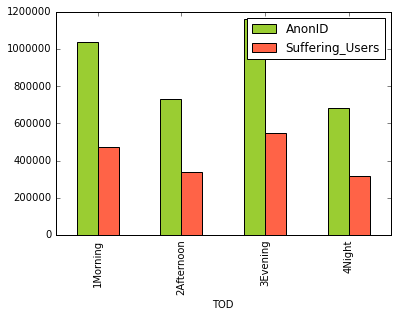

In [20]:
sufferingUsers = clickless.groupby(['TOD'])['AnonID'].count().to_frame()
timing = timedf.groupby(['TOD'])['AnonID'].count().to_frame()
timing['Suffering_Users'] = sufferingUsers.AnonID
timing.plot(kind='bar', color=['yellowgreen','tomato'])

In [21]:
durationmax = timedf.groupby(['AnonID'])['QueryTimeStamp'].max()
durationmin = timedf.groupby(['AnonID'])['QueryTimeStamp'].min()

In [22]:
dmax = durationmax.to_frame()
dmin = durationmin.to_frame()
dmin['AnonID'] = list(dmin.index)
dmax['AnonID'] = list(dmax.index)
dmin = dmin.reset_index(drop=True)
dmax = dmax.reset_index(drop=True)
duration = pd.merge(dmax, dmin, on='AnonID', how='inner')
duration = duration.rename(columns={'QueryTimeStamp_x': 'MaxTime', 'QueryTimeStamp_y': 'MinTime'})
dulist = duration['MaxTime'].apply(time2date) - duration['MinTime'].apply(time2date)
duration['TimeSpent'] = dulist
duration = duration[['AnonID','TimeSpent']]
timesummary = duration.TimeSpent.describe().to_frame()

In [23]:
def deltaformat(x):
    x = str(x)
    if 'days' in x:
        return x.split("days")[1].split('.')[0]
    elif '.' in x:
        return x.split("days")[1].split('.')[0]
    else:
        return x
    
timesummary.TimeSpent = timesummary.TimeSpent.apply(deltaformat)
timesummary

,TimeSpent
count,66000
mean,12:10:13
std,08:22:37
min,00:00:00
25%,04:41:26
50%,12:15:41
75%,21:03:37
max,23:59:59


In [24]:
#Satisfaction Levels
def numRanks(df):
    x =df[df.ItemRank<=2.0].ItemRank.count()/df.Query.count() 
    return x

In [25]:
userDict= {}
for user in userlist:
    userDict[user]= data[data.AnonID==user]

In [27]:
userUsage={}
singleUser=0
for user in userDict.keys():
    if numRanks(userDict[user])>0.8:
        if userDict[user].shape[0]==1:
            singleUser= singleUser+1
        userUsage[user]=numRanks(userDict[user])

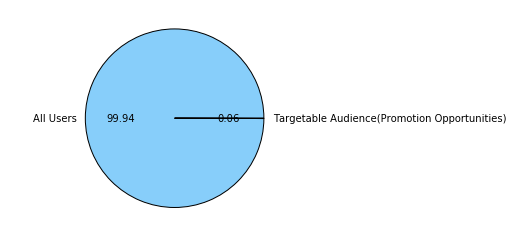

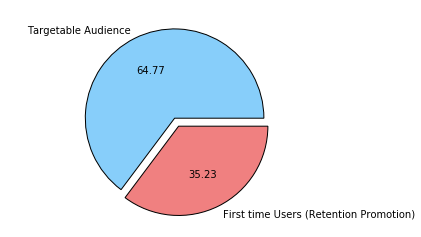

In [28]:
plt.figure()
values1 = [(data.shape[0]/data.shape[0]),(len(userUsage)/data.shape[0])] 
labels1 = ['All Users', 'Targetable Audience(Promotion Opportunities)'] 
colors1 = ['lightskyblue', 'lightcoral'] 
plt.axis('equal')
plt.pie(values1, labels=labels1, autopct='%.2f', colors=colors1)
plt.savefig('TargetAudience.png')
plt.show()
values2 = [(len(userUsage)/len(userUsage)), (singleUser/len(userUsage))] 
labels2 = ['Targetable Audience', 'First time Users (Retention Promotion)'] 
# colors2= ['yellowgreen', 'mediumpurple']
plt.axis('equal')
explode1 = (0, 0.1)
plt.pie(values2, labels=labels2, autopct='%.2f', explode=explode1, colors=colors1)
plt.savefig('RententionPlans.png')
plt.show()

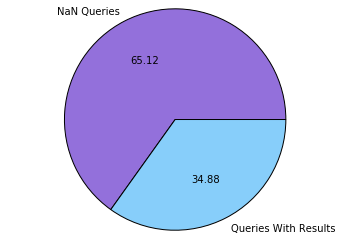

In [29]:
cleandata = data.dropna()
plt.figure()
values1 = [data.shape[0]/data.shape[0],cleandata.shape[0]/data.shape[0]] 
labels1 = ['NaN Queries', 'Queries With Results'] 
colors1 = ['mediumpurple','lightskyblue'] 
plt.pie(values1, labels=labels1, autopct='%.2f', colors=colors1)
plt.axis('equal')
plt.savefig('NaNQueries.png')
plt.show()

In [30]:
clickless['QueryDay'] = pd.to_datetime(timedf['QueryTime']).apply(lambda x: x.date())

In [31]:
NaNdays = clickless.groupby(['QueryDay'])['AnonID'].count().to_frame()
alldays = timedf.groupby(['QueryDate'])['AnonID'].count().to_frame()
NaNdays['Date'] = list(NaNdays.index)
alldays['Date'] = list(alldays.index)
compDays = pd.merge(NaNdays, alldays, on='Date')
compDays['NanRequests'] = compDays['AnonID_x']
compDays['AllRequests'] = compDays['AnonID_y']
compDays = compDays[['Date', 'AllRequests','NanRequests']]
compDays = compDays.sort_values(by='NanRequests', ascending=False)

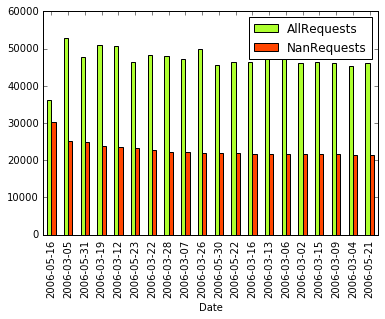

In [32]:
compDays.head(20).plot(x='Date', kind='bar', color=['greenyellow', 'orangered'])

In [157]:
data2 = data.dropna()
data2['QueryDay'] = pd.to_datetime(data2['QueryTime']).apply(lambda x: x.date())
data2['QueryTimeStamp'] = pd.to_datetime(data2['QueryTime']).apply(lambda x: x.time())
data2['TOD'] = data2['QueryTimeStamp'].apply(lambda x: timeOfDay(x))
data2['TOD_code'] = data2['TOD'].apply(lambda x: list(x)[0])
data2['Hours']= data2.QueryTimeStamp.apply(lambda x: date2hours(x))

In [158]:
data2.head()

,AnonID,Query,QueryTime,ItemRank,ClickURL,QueryDay,QueryTimeStamp,TOD,Hours,TOD_code
2,479,family guy movie references,2006-03-03 22:37:46,1.0,http://www.familyguyfiles.com,2006-03-03,22:37:46,4Night,22.629444,4
3,479,top grossing movies of all time,2006-03-03 22:42:42,1.0,http://movieweb.com,2006-03-03,22:42:42,4Night,22.711667,4
4,479,top grossing movies of all time,2006-03-03 22:42:42,2.0,http://www.imdb.com,2006-03-03,22:42:42,4Night,22.711667,4
5,479,car decals,2006-03-03 23:20:12,4.0,http://www.decaljunky.com,2006-03-03,23:20:12,4Night,23.336667,4
6,479,car decals,2006-03-03 23:20:12,1.0,http://www.modernimage.net,2006-03-03,23:20:12,4Night,23.336667,4


In [170]:
target = data2.ItemRank
predvar= data2[['AnonID', 'Hours', 'TOD_code']]
predictors=predvar.copy()
predictors['TOD_code']=preprocessing.scale(predictors['TOD_code'].astype('float64'))

In [171]:
pred_train, pred_test, tar_train, tar_test = train_test_split(predictors, target, 
                                                              test_size=.3, random_state=123)

In [172]:
from sklearn.linear_model import LassoLarsCV
model=LassoLarsCV(cv=3, precompute=False).fit(pred_train,tar_train)
dict(zip(predictors.columns, model.coef_))

{'AnonID': -2.2262240956329524e-08,
 'Hours': -0.26843668456519959,
 'TOD_code': 1.5370899917157064}

In [191]:
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.cross_validation import train_test_split
clustervar = data2.copy()

In [192]:
def date2hours(d):
    h = d.hour + d.minute / 60. + d.second / 3600
    return float(h)

In [193]:
clustervar['Hours']= clustervar.QueryTimeStamp.apply(lambda x: date2hours(x))

In [194]:
clustervar = clustervar[['ItemRank', 'Hours']]
clustervar['ItemRank']=preprocessing.scale(clustervar['ItemRank'].astype('float64'))
clustervar['Hours']=preprocessing.scale(clustervar['Hours'].astype('float64'))

In [195]:
clustervar.head()

,ItemRank,Hours
2,-0.290094,1.21452
3,-0.290094,1.22752
4,-0.241466,1.22752
5,-0.144212,1.32634
6,-0.290094,1.32634


In [196]:
clus_train, clus_test = train_test_split(clustervar, test_size=.3, random_state=123)

# k-means cluster analysis for 1-9 clusters                                                           
from scipy.spatial.distance import cdist
clusters=range(1,10)
meandist=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(clus_train)
    clusassign=model.predict(clus_train)
    meandist.append(sum(np.min(cdist(clus_train, model.cluster_centers_, 'euclidean'), axis=1)) 
    / clus_train.shape[0])

In [223]:
C = clustervar.as_matrix

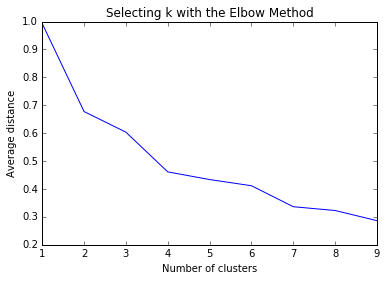

In [197]:
plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method')

In [203]:
model3=KMeans(n_clusters=4)
model3.fit(clus_train)
clusassign=model3.predict(clus_train)
# plot clusters

from sklearn.decomposition import PCA
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(clus_train)

PCA(copy=True, n_components=2, whiten=False)

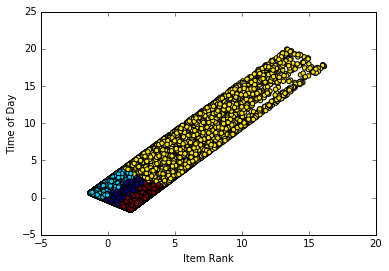

In [224]:
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=model3.labels_,)
plt.xlabel('Item Rank')
plt.ylabel('Time of Day')
plt.show()